In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- CONFIG ---
num_experts = 4
top_k = 2
hidden_dim = 8

# --- Dummy input token ---
input_token = torch.randn(1, hidden_dim)  # shape: [1, hidden_dim]
target = torch.tensor([[100.0]])

# --- Learnable router (Linear layer that outputs logits over experts) ---
router = nn.Linear(hidden_dim, num_experts, bias=False)

# --- Experts: Linear(1 → 1) layers ---
experts = [nn.Linear(1, 1, bias=False) for _ in range(num_experts)]
for i, expert in enumerate(experts):
    expert.weight.data.fill_(i + 1.0)  # make output visible by weight

# === FORWARD ===
logits = router(input_token)                  # [1, num_experts]
logits.retain_grad()
probs = F.softmax(logits, dim=-1)             # [1, num_experts]
topk_vals, topk_indices = torch.topk(probs, top_k, dim=-1)

# Compute expert outputs (for selected indices only)
expert_outputs = []
for i in range(top_k):
    expert_idx = topk_indices[0, i].item()
    weight = topk_vals[0, i]
    expert_out = experts[expert_idx](torch.tensor([[1.0]]))  # dummy expert input
    expert_outputs.append(weight * expert_out)

output = sum(expert_outputs)
loss = F.mse_loss(output, target)
loss.backward()

# === PRINT GRADS ===
print("\n--- ROUTER ---")
print("Router logits:", logits.data.numpy())
print("Router grad (dL/dlogits):", logits.grad.numpy())
print("Router weight grad (dL/dW):", router.weight.grad.numpy())

print("\n--- EXPERTS ---")
for i, expert in enumerate(experts):
    grad = expert.weight.grad
    print(f"Expert {i} grad:", grad.item() if grad is not None else 0.0)


--- ROUTER ---
Router logits: [[ 1.0215455   0.4172941  -1.0122901  -0.10469508]]
Router grad (dL/dlogits): [[  4.515164 -51.567127  13.527067  33.52487 ]]
Router weight grad (dL/dW): [[   1.0617994   14.216541    -1.4554664    4.6863036    8.944152
    -1.7700742    0.53402    -10.652513 ]
 [ -12.126679  -162.36536     16.622702   -53.52169   -102.15005
    20.215797    -6.0989766  121.661026 ]
 [   3.1810656   42.591614    -4.3604603   14.039788    26.795958
    -5.3029995    1.5998809  -31.91407  ]
 [   7.883809   105.55713    -10.806767    34.795574    66.40989
   -13.1427145    3.9650726  -79.09439  ]]

--- EXPERTS ---
Expert 0 grad: -98.87690734863281
Expert 1 grad: -54.03458786010742
Expert 2 grad: 0.0
Expert 3 grad: 0.0


In [5]:
logits.grad

/tmp/ipykernel_3456714/1055277058.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/build/aten/src/ATen/core/TensorBody.h:489.)
  logits.grad


In [3]:
import torch
import torch.nn.functional as F

# Logits for routing
logits = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)

# Dummy experts: Linear(1 → 1) layers
expert_weights = [torch.nn.Linear(1, 1, bias=False) for _ in range(4)]

# Set weights to deterministic values for visibility
for i, expert in enumerate(expert_weights):
    expert.weight.data.fill_(i + 1.0)  # expert[i] multiplies input by i+1

# Dummy input token
input_token = torch.tensor([[1.0]])  # shape (1, 1)

# Target output
target = torch.tensor([[100.0]])

# --- ROUTER ---
softmax_probs = F.softmax(logits, dim=0)
topk_vals, topk_indices = torch.topk(softmax_probs, k=2)

# --- EXPERT COMPUTATION (only for selected experts) ---
expert_outputs = []
for i, idx in enumerate(topk_indices):
    expert_idx = idx.item()
    weight = topk_vals[i]
    out = expert_weights[expert_idx](input_token)  # actual expert computation
    expert_outputs.append(weight * out)

output = sum(expert_outputs)
loss = F.mse_loss(output, target)
loss.backward()

# --- Collect Gradients ---
print("Logits:", logits.data.numpy())
print("Gradients wrt logits:", logits.grad.numpy())
for i, expert in enumerate(expert_weights):
    grad = expert.weight.grad
    print(f"Expert {i} weight grad:", grad.item() if grad is not None else 0.0)

Logits: [1. 2. 3. 4.]
Gradients wrt logits: [ 20.37842   55.39429   13.118414 -88.8911  ]
Expert 0 weight grad: 0.0
Expert 1 weight grad: 0.0
Expert 2 weight grad: -45.81962585449219
Expert 3 weight grad: -124.55065155029297


In [1]:
import torch
import torch.nn.functional as F

# Toy logits simulating router output
logits = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)  # shape: (4,)

# Simulate expert outputs (just fixed for toy example)
expert_outputs = torch.tensor([
    10.0, 20.0, 30.0, 40.0  # one output per expert
])

# === PATH 1: Full softmax ===
softmax_all = F.softmax(logits, dim=0)
output_soft = torch.sum(softmax_all * expert_outputs)
loss_soft = (output_soft - 25.0)**2  # arbitrary target
loss_soft.backward(retain_graph=True)
print("=== FULL SOFTMAX ===")
print("Logits:", logits.detach().numpy())
print("Softmax:", softmax_all.detach().numpy())
print("Gradients (softmax all):", logits.grad.detach().numpy())

# Save for comparison
grad_soft = logits.grad.clone()
logits.grad.zero_()

# === PATH 2: Softmax + Top‑k ===
softmax_all = F.softmax(logits, dim=0)  # Recompute fresh copy
topk_vals, topk_indices = torch.topk(softmax_all, k=2)
topk_expert_outputs = expert_outputs[topk_indices]
output_topk = torch.sum(topk_vals * topk_expert_outputs)
loss_topk = (output_topk - 25.0)**2
loss_topk.backward()
print("\n=== TOP‑K ===")
print("Top‑k indices:", topk_indices.tolist())
print("Top‑k probs:", topk_vals.detach().numpy())
print("Top‑k expert outputs:", topk_expert_outputs.detach().numpy())
print("Gradients (top‑k only):", logits.grad.detach().numpy())


logits.grad.zero_()

# BLOCKING gradient from non-topk entries manually
softmax_all = F.softmax(logits, dim=0)
mask = torch.zeros_like(softmax_all)
mask[topk_indices] = 1.0
masked_probs = softmax_all * mask.detach()  # .detach() kills gradient flow from mask
masked_probs = masked_probs / masked_probs.sum()  # renormalize

output_hardtopk = torch.sum(masked_probs * expert_outputs)
loss_hardtopk = (output_hardtopk - 25.0)**2
loss_hardtopk.backward()
print("=== HARD TOP-K (Masked) ===")
print("Gradients:", logits.grad.detach().numpy())

=== FULL SOFTMAX ===
Logits: [1. 2. 3. 4.]
Softmax: [0.0320586  0.08714432 0.23688284 0.6439143 ]
Gradients (softmax all): [-15.864773 -25.824112 -23.16873   64.857544]

=== TOP‑K ===
Top‑k indices: [3, 2]
Top‑k probs: [0.6439143  0.23688284]
Top‑k expert outputs: [40. 30.]
Gradients (top‑k only): [-16.568146 -45.036892 -10.665584  72.270615]
=== HARD TOP-K (Masked) ===
Gradients: [-9.7835095e-07 -2.6594337e-06 -4.8408150e+01  4.8408154e+01]


In [7]:
masked_probs

tensor([0.0000, 0.0000, 0.2689, 0.7311], grad_fn=<DivBackward0>)

In [22]:
# BLOCKING gradient from non-topk entries manually
softmax_all = F.softmax(logits, dim=0)
mask = torch.zeros_like(softmax_all)
mask[topk_indices] = 1.0
masked_probs = softmax_all * mask.detach()  # .detach() kills gradient flow from mask
masked_probs = masked_probs / masked_probs.sum()  # renormalize

output_hardtopk = torch.sum(masked_probs * expert_outputs)
loss_hardtopk = (output_hardtopk - 25.0)**2
loss_hardtopk.backward()
print("=== HARD TOP-K (Masked) ===")
print("Gradients:", logits.grad.detach().numpy())

=== HARD TOP-K (Masked) ===
Gradients: [-1.5653613e-05 -4.2550946e-05 -7.7453033e+02  7.7453033e+02]


In [1]:
import torch
n_toks = 24
n_exps = 3

cost = torch.exp(torch.randn((n_toks, n_exps)))
d0 = torch.ones(cost.size(0))
d1 = torch.ones(cost.size(1))
eps = 0.00000001
error = 1e9
d1_old = d1
tol= 0.0001

while error > tol:
    d0 = (1 / d0.size(0)) * 1 / (torch.sum(d1 * cost, 1) + eps)
    d1 = (1 / d1.size(0)) * 1 / (torch.sum(d0.unsqueeze(1) * cost, 0) + eps)
    error = torch.mean(torch.abs(d1_old - d1))
    d1_old = d1
    res = d1 * cost * d0.unsqueeze(1)


In [18]:
d11 = torch.diag(d1)

In [19]:
d00 = torch.diag(d0)

In [21]:
d1 * cost * d0.unsqueeze(1)

tensor([[0.0164, 0.0238, 0.0015],
        [0.0088, 0.0114, 0.0214],
        [0.0263, 0.0140, 0.0013],
        [0.0100, 0.0292, 0.0024],
        [0.0265, 0.0105, 0.0046],
        [0.0064, 0.0286, 0.0067],
        [0.0011, 0.0220, 0.0186],
        [0.0227, 0.0066, 0.0123],
        [0.0201, 0.0144, 0.0071],
        [0.0193, 0.0206, 0.0018],
        [0.0237, 0.0148, 0.0032],
        [0.0074, 0.0150, 0.0193],
        [0.0103, 0.0139, 0.0175],
        [0.0023, 0.0029, 0.0364],
        [0.0109, 0.0053, 0.0254],
        [0.0033, 0.0038, 0.0345],
        [0.0091, 0.0111, 0.0215],
        [0.0209, 0.0014, 0.0194],
        [0.0257, 0.0064, 0.0096],
        [0.0093, 0.0091, 0.0232],
        [0.0028, 0.0232, 0.0157],
        [0.0036, 0.0152, 0.0229],
        [0.0146, 0.0226, 0.0045],
        [0.0317, 0.0075, 0.0025]])

In [20]:
torch.matmul(torch.matmul(d00, cost), d11)

tensor([[0.0164, 0.0238, 0.0015],
        [0.0088, 0.0114, 0.0214],
        [0.0263, 0.0140, 0.0013],
        [0.0100, 0.0292, 0.0024],
        [0.0265, 0.0105, 0.0046],
        [0.0064, 0.0286, 0.0067],
        [0.0011, 0.0220, 0.0186],
        [0.0227, 0.0066, 0.0123],
        [0.0201, 0.0144, 0.0071],
        [0.0193, 0.0206, 0.0018],
        [0.0237, 0.0148, 0.0032],
        [0.0074, 0.0150, 0.0193],
        [0.0103, 0.0139, 0.0175],
        [0.0023, 0.0029, 0.0364],
        [0.0109, 0.0053, 0.0254],
        [0.0033, 0.0038, 0.0345],
        [0.0091, 0.0111, 0.0215],
        [0.0209, 0.0014, 0.0194],
        [0.0257, 0.0064, 0.0096],
        [0.0093, 0.0091, 0.0232],
        [0.0028, 0.0232, 0.0157],
        [0.0036, 0.0152, 0.0229],
        [0.0146, 0.0226, 0.0045],
        [0.0317, 0.0075, 0.0025]])

In [14]:
d0.unsqueeze(1).shape

torch.Size([24, 1])

In [15]:
d1.shape

torch.Size([3])

In [16]:
cost.shape

torch.Size([24, 3])

In [17]:
d0.unsqueeze(1).shape

torch.Size([24, 1])

In [ ]:
cost

tensor([[ 1.2995,  2.2494,  0.1651],
        [ 1.2802,  1.9789,  4.3313],
        [ 3.6705,  2.3270,  0.2601],
        [ 1.5767,  5.4722,  0.5367],
        [ 1.0312,  0.4881,  0.2503],
        [ 0.6219,  3.3286,  0.9123],
        [ 0.1586,  3.8598,  3.8309],
        [ 0.6262,  0.2165,  0.4740],
        [ 0.2932,  0.2506,  0.1443],
        [ 3.4314,  4.3756,  0.4461],
        [ 1.6969,  1.2583,  0.3174],
        [ 0.4274,  1.0245,  1.5425],
        [ 0.9753,  1.5771,  2.3163],
        [ 0.3114,  0.4748,  6.8535],
        [ 0.6366,  0.3703,  2.0583],
        [ 0.9215,  1.2834, 13.4757],
        [ 0.9387,  1.3653,  3.0908],
        [ 1.2610,  0.0974,  1.6243],
        [ 1.6473,  0.4878,  0.8534],
        [ 0.7594,  0.8814,  2.6336],
        [ 0.2954,  2.9378,  2.3268],
        [ 0.1939,  0.9824,  1.7284],
        [ 0.9141,  1.6922,  0.3901],
        [ 3.5575,  0.9991,  0.3908]])

In [5]:
d0 * cost

RuntimeError: The size of tensor a (24) must match the size of tensor b (3) at non-singleton dimension 1

In [74]:
res[0].sum()

tensor(0.0417)

In [75]:
1/n_toks

0.041666666666666664

In [46]:
1/n_exps

0.3333333333333333

tensor(0.1250)

In [41]:
1/n_exps

0.3333333333333333

In [42]:
res[0].sum()

tensor(0.1250)

In [1]:
import matplotlib.pyplot as plt

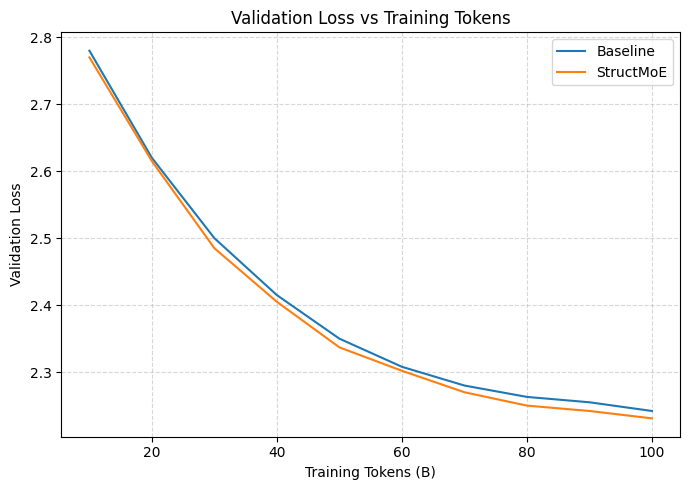

In [5]:

# 125M


# Mocked data points based on the plot you shared
tokens = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

baseline_loss = [2.78, 2.62, 2.50, 2.415, 2.35, 2.308, 2.28, 2.263, 2.255, 2.242]
smoe_loss     = [2.77, 2.615, 2.485, 2.405, 2.337, 2.302, 2.27, 2.25, 2.242, 2.231]

plt.figure(figsize=(7,5))

plt.plot(tokens, baseline_loss, label='Baseline')
plt.plot(tokens, smoe_loss, label='StructMoE')

plt.xlabel('Training Tokens (B)')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Training Tokens')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('125M_validation_loss.pdf')
plt.show()

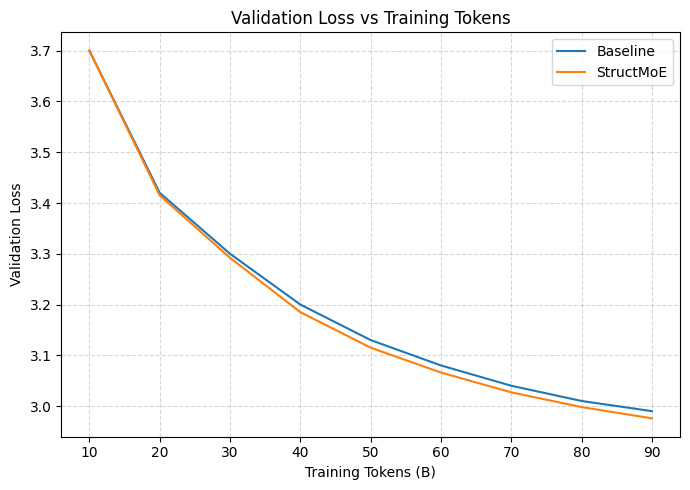

In [6]:
#410M

import matplotlib.pyplot as plt

# Approximate data points based on your plot
tokens = [10, 20, 30, 40, 50, 60, 70, 80, 90]

baseline_loss = [3.70, 3.42, 3.30, 3.20, 3.13, 3.08, 3.04, 3.01, 2.99]
smoe_loss     = [3.70, 3.415, 3.292, 3.185, 3.115, 3.066, 3.027, 2.998, 2.9758]

plt.figure(figsize=(7,5))

plt.plot(tokens, baseline_loss, label='Baseline')
plt.plot(tokens, smoe_loss, label='StructMoE')

plt.xlabel('Training Tokens (B)')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Training Tokens')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('410M_validation_loss.pdf')
plt.show()

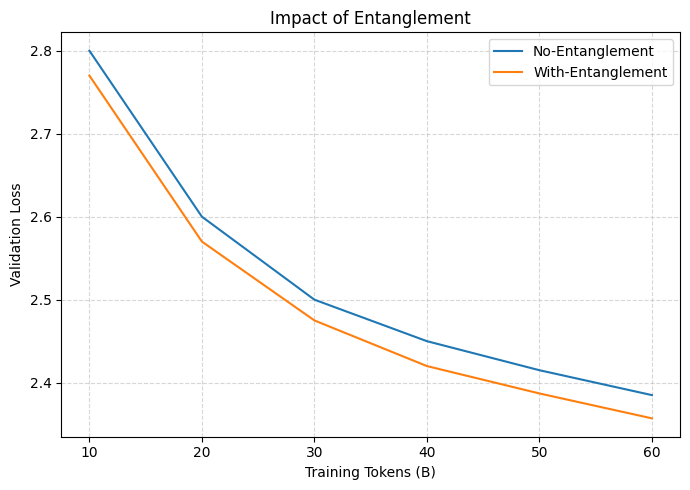

In [7]:
# Ent no Ent
import matplotlib.pyplot as plt

# Approximate data points based on your plot
tokens = [10, 20, 30, 40, 50, 60]

no_entanglement = [2.80, 2.60, 2.50, 2.45, 2.415, 2.385]
with_entanglement = [2.77, 2.57, 2.475, 2.42, 2.387, 2.357]

plt.figure(figsize=(7,5))


plt.plot(tokens, no_entanglement, label='No-Entanglement')
plt.plot(tokens, with_entanglement, label='With-Entanglement')


plt.xlabel('Training Tokens (B)')
plt.ylabel('Validation Loss')
plt.title('Impact of Entanglement')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('125M_entanglement_ablation.pdf')
plt.show()

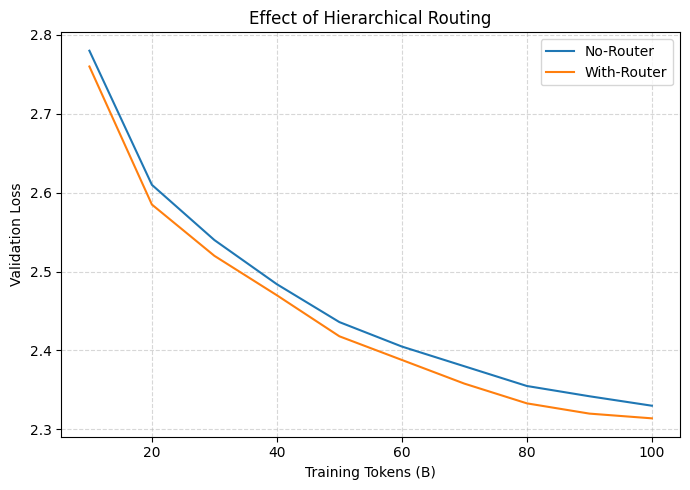

In [8]:
# Router no router

import matplotlib.pyplot as plt

# Approximate data points from your plot
tokens = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

no_router =   [2.78, 2.61, 2.54, 2.484, 2.436, 2.405, 2.38, 2.355, 2.342, 2.33]
with_router = [2.76, 2.585, 2.52, 2.47, 2.418, 2.388, 2.358, 2.333, 2.320, 2.314]

plt.figure(figsize=(7,5))

plt.plot(tokens, no_router, label='No-Router')
plt.plot(tokens, with_router, label='With-Router')


plt.xlabel('Training Tokens (B)')
plt.ylabel('Validation Loss')
plt.title('Effect of Hierarchical Routing')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('125M_router_ablation.pdf')
plt.show()

In [1]:
import numpy as np

In [9]:
hid = 768
inter = 3072
num_exps = 4
num_loras = 16
lora_rank = 16
lora_top_k = 2


In [10]:
hetro_flops = 2 * lora_top_k * ((hid * lora_rank) + (inter * lora_rank))
hetro_params = 2 * num_loras * ((hid * lora_rank) + (inter * lora_rank))

In [11]:
expert_params = hid * inter * 2
expert_flops = hid * inter * 2

moe_expert_params = 4 * expert_params
moe_expert_flops = expert_params

minion_expert_params = 3 * expert_params + hetro_params
minion_expert_flops =  (0.75 * moe_expert_flops) + (0.25 * hetro_flops)


In [12]:
((moe_expert_flops - minion_expert_flops) / moe_expert_flops) * 100

23.697916666666664

In [13]:
minion_expert_params

16121856

In [14]:
minion_expert_flops

3600384.0

In [8]:
(((768 * 2624) * 2) - minion_expert_flops)/ ((768 * 2624) * 2) 

0.10670731707317073

In [16]:
((768 * 2624) * 2) * 4

16121856